# env 및 랭스미스

In [123]:
from langsmith import Client
from dotenv import load_dotenv

client = Client()
load_dotenv()

True

# 그래프 상태 정의

In [224]:
from typing import TypedDict

class RealEstateState(TypedDict): # 그래프의 상태를 정의하는 클래스
    real_estate_type: str  # 부동산 유형 (예: 아파트, 상가)
    questions: list[str]        # 유저 질문
    query: str             # 생성된 SQL 쿼리
    results: list[dict]          # 쿼리 결과

# 노드 정의

In [225]:
from langgraph.graph import StateGraph, START, END
from langchain.prompts import PromptTemplate
from langchain_openai.chat_models.base import ChatOpenAI

# Step 1: LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)

# Step 2: StateGraph 정의
graph = StateGraph(RealEstateState)

# Step 3: 노드 정의

## 필터링 노드
def filter_node(state: RealEstateState) -> RealEstateState :
    filter_prompt = PromptTemplate(
        input_variables=["questions"],
        template=""" '{questions}'이 부동산과 관련된 질문인지를 파악하고 다음과 같은 규칙을 지켜라
        1. 부동산 관련 질문이 아니면 'None'을 반환해라
        2. 부동산 관련 질문 중 에서 매매면 '매매'를 반환해라
        3. 전세 그리고 월세랑 관련된 질문이면 '전월세'를 반환해라.
        """)
    
    prompt=filter_prompt.format(questions=state["questions"])

    response = llm(messages=[{"role": "system", "content": prompt}])

    real_estate_type = response.content
    
    return RealEstateState(real_estate_type=real_estate_type)

def re_questions(state: RealEstateState) -> RealEstateState:

    print("=================================")
    print("[re_questions] 질문이 부동산 관련이 아니거나 제대로 인식되지 않았습니다.")
    new_question = input("새로운 부동산 질문을 입력해주세요: ")
    print("=================================")

    # 수정된 질문을 state에 업데이트

    return RealEstateState(questions=new_question)

def fiter_router(state: RealEstateState):
    # This is the router
    real_estate_type = state["real_estate_type"]

    if real_estate_type == "매매":
        return "매매"
    elif real_estate_type == "전월세":
        return "전월세"
    else:
        return 'None'
    


# DB 생성 조회

In [226]:
from langchain_community.utilities import SQLDatabase
from langchain_experimental.sql import SQLDatabaseChain
import sqlite3
from langchain_community.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool

def get_db_engine(db_path):
    """로컬 SQLite DB 파일과 연결된 엔진을 생성합니다."""
    try:
        # SQLite DB 파일과 연결
        connection = sqlite3.connect(db_path, check_same_thread=False)
        
        # SQLAlchemy 엔진 생성
        engine = create_engine(
            f"sqlite:///{db_path}",
            poolclass=StaticPool,
            connect_args={"check_same_thread": False}
        )
        
        return engine
    
    except Exception as e:
        print(f"데이터베이스 연결 중 오류 발생: {str(e)}")
        return None

# DB 파일 경로 지정
db_path = './data/real_estate.db'

engine = get_db_engine(db_path)

db = SQLDatabase(
    engine,
    sample_rows_in_table_info=False  # 샘플 행 조회 비활성화
)

sql_chain = SQLDatabaseChain(llm=llm, database=db, verbose=True)

c:\Users\USER\anaconda3\envs\nlp\lib\site-packages\langchain_experimental\sql\base.py:77: UserWarning: Directly instantiating an SQLDatabaseChain with an llm is deprecated. Please instantiate with llm_chain argument or using the from_llm class method.
  warnings.warn(


# 매매, 전월세 프롬프트 및 노드생성


In [227]:
def property_rental(state: RealEstateState) -> RealEstateState:
    property_rental = db.get_table_info(table_names=["property_rentals", "property_info", "property_locations"])

    rental_prompt = """
    질문:
    {questions}

    사용 가능한 테이블 스키마:
    {property_rental}

    당신은 SQL 전문가입니다. 
    데이터베이스는 {dialect} 방언을 사용합니다.

    다음 규칙을 따라주세요:
    1. 한국어로 응답해주세요.
    2. SQL 쿼리를 작성할 때는 명확하고 효율적이어야 합니다.
    3. 결과는 최대 {top_k}개까지만 보여주세요.
    4. 금액에 관련된 쿼리를 작성할 때는 쉼표(,)를 제거하고 숫자로 변환해야 합니다.
    5. 에러가 발생하면 원인을 설명하고 수정된 쿼리를 제시해주세요.
    6. rental_type이 30051B1는 전세입니다.
    7. rental_type이 30051B2는 월세입니다.

    SELECT 
        pl.sigungu,
        pi.description,
        pr.deposit as "보증금(만원)",
        pl.latitude,
        pl.longitude
    FROM property_rentals pr
    JOIN property_info pi ON pr.property_id = pi.property_id
    JOIN property_locations pl ON pi.location_id = pl.location_id
    WHERE pl.sigungu LIKE '%강남구%'
    AND pr.rental_type = '30051B1'
    AND CAST(REPLACE(pr.deposit, ',', '') AS DECIMAL) <= 10000;

    이런식으로 쿼리를 짜줘.
    """

    prompt=rental_prompt.format(
        dialect="SQLite",
        top_k=5, 
        property_rental=property_rental,
        questions=state["questions"]
    )

    response = llm(messages=[{"role": "system", "content": prompt}])

    llm_query = response.content

    return RealEstateState(query=llm_query)


In [228]:
def property_sales(state: RealEstateState) -> RealEstateState:
    property_sales = db.get_table_info(table_names=["property_sales", "property_info", "property_locations"])

    sales_prompt = """
    당신은 SQL 전문가로서 한국어로 질문에 맞는 SQL 쿼리를 작성하세요. 데이터베이스는 특정 SQL 방언을 사용하며, 테이블 스키마는 주어진 대로 사용해야 합니다.

- 사용 가능한 테이블 스키마: {property_sales}
- 데이터베이스 SQL 방언: {dialect}

다음 규칙을 준수하세요:

1. 한국어로 답변을 작성하세요.
2. 작성한 SQL 쿼리는 명확하고 효율적이어야 합니다.
3. 쿼리 결과는 최대 {top_k}개까지만 출력하도록 하세요.
4. 금액 관련 쿼리를 작성할 때는 금액에 포함된 쉼표(,)를 제거하고 숫자로 변환해야 합니다.
5. 에러가 발생하면 원인을 설명하고 수정된 쿼리를 제시하세요.

# Steps

1. 질문 분석: 주어진 질문을 분석하여 필요한 데이터를 정의합니다.
2. SQL 쿼리 작성: 질문에 따라 명확하고 효율적인 SQL 쿼리를 작성합니다.
3. 쿼리 변환: 필요에 따라 금액에 포함된 쉼표(,)를 제거하고 숫자로 변환하는 과정을 포함합니다.
4. 에러 관리: 에러 발생 시, 원인을 설명하고 수정된 쿼리를 제공합니다.

# Output Format

다음과 같은 구조의 SQL 쿼리와 추가 설명을 제공합니다.
- SQL 쿼리: 명확한 SQL 코드
- 설명: 쿼리의 목적 및 주요 기능 설명

# Examples

- 예시 질문: "서울시 강남구 10억 이하 매물을 추천해줘"
  
  **SQL 쿼리**
  ```sql
  SELECT 
      pl.sigungu,
      pi.description,
      ps.price as "금액(만원)",
      pl.longitude
  FROM property_sales ps
  JOIN property_info pi ON ps.property_id = pi.property_id
  JOIN property_locations pl ON pi.location_id = pl.location_id
  WHERE pl.sigungu LIKE '%강남구%'
  AND CAST(REPLACE(ps.price, ',', '') AS DECIMAL) <= 100000
  ```

  **설명**
  - '강남구'에 위치한 10억 이하의 매물을 조회하는 쿼리
  - 금액에 포함된 쉼표를 제거하고 숫자 비교를 수행

# Notes

- 최적의 SQL 방언을 사용하여 쿼리를 작성하세요.
- 주어진 테이블 스키마를 기반으로 하여 쿼리를 작성해야 합니다.
- 숫자 변환 과정에서 발생할 수 있는 오류를 미리 점검하세요.

    """
    prompt=sales_prompt.format(
        dialect="SQLite",
        top_k=5, 
        property_rental=property_sales,
    )

    
    response = llm(messages=[{"role": "system", "content": prompt}])

    llm_query = response.content

    return RealEstateState(query=llm_query)


In [229]:
graph.add_node("Filter Question", filter_node)
graph.add_node('Re_Questions', re_questions)
graph.add_node("Property Rentals", property_rental)
graph.add_node('Property Sales', property_sales)

{'real_estate_type': '전월세', 'questions': '강남 전세 10억 추천', 'query': '아래는 강남구에서 전세로 10억 원 이하의 매물을 조회하는 SQL 쿼리입니다. 보증금은 만 원 단위로 표시됩니다.\n\n```sql\nSELECT \n    pl.sigungu,\n    pi.description,\n    CAST(REPLACE(pr.deposit, \',\', \'\') AS DECIMAL) / 10000 AS "보증금(만원)",\n    pl.latitude,\n    pl.longitude\nFROM property_rentals pr\nJOIN property_info pi ON pr.property_id = pi.property_id\nJOIN property_locations pl ON pi.location_id = pl.location_id\nWHERE pl.sigungu LIKE \'%강남구%\'\nAND pr.rental_type = \'30051B1\'\nAND CAST(REPLACE(pr.deposit, \',\', \'\') AS DECIMAL) <= 1000000\nLIMIT 5;\n```\n\n이 쿼리에서는 `pr.deposit`의 값을 만 원 단위로 변환하기 위해 10000으로 나누었고, 보증금이 10억 원 이하인 매물을 선택했습니다. `LIMIT 5`를 통해 최대 5개의 결과만 표시하도록 설정했습니다.'}


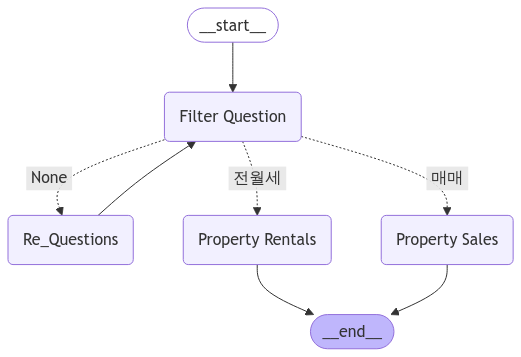

In [230]:
from IPython.display import Image, display

# 조건부 엣지 추가
graph.add_conditional_edges(
    "Filter Question",
    fiter_router,
    { 'None': "Re_Questions", '매매': "Property Sales", '전월세': 'Property Rentals'}
)

# START에서 'Filter Question' 노드로 엣지 추가
graph.add_edge(START, "Filter Question")
graph.add_edge("Re_Questions", "Filter Question")
graph.add_edge("Property Rentals", END)
graph.add_edge("Property Sales", END)


# 그래프 컴파일
app = graph.compile()

# 그래프 실행
result = app.invoke({'questions':input()})
print(result) 


graph_image = app.get_graph().draw_mermaid_png()
display(Image(graph_image))